# Visión por Computadora 1
## TP 3 
## Alumno: Santiago Fux

In [19]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
%matplotlib inline

# OpenCV-Python utiliza NumPy para el manejo de imágenes
import numpy as np
# cv2 es el módulo python para acceder a OpenCV 
import cv2 as cv
# Usamos las poderosas herramientas de graficación de matplotlib para mostrar imágenes, perfiles, histogramas, etc
import matplotlib.pyplot as plt


#### Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template


##### 1. Obtener una detección del logo en cada imagen sin falsos positivos

##### 2. Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del item 2

##### 3. Generalizar el algoritmo del item 2 para todas las imágenes.

__Importante__: Se implemento el punto 2 y 3 en simultáneo

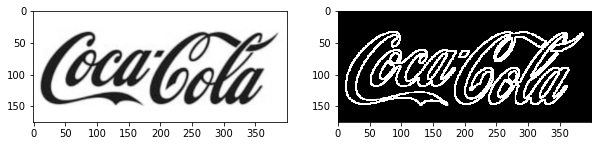

In [20]:
#leo imagen template en gris
template_color = cv.imread('template/pattern.png')
template = cv.cvtColor(template_color, cv.COLOR_BGR2GRAY)

plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(template, cmap='gray')


# Obtenemos los bordes por Canny
#===============================
template_edge = cv.Canny(template, 200, 260, apertureSize = 3)
ret, template_edge = cv.threshold(template_edge,128,255,cv.THRESH_BINARY)
plt.subplot(1,2,2)
plt.imshow(template_edge, cmap='gray', vmin=0, vmax=1)



In [21]:
# leo imágenes a procesar
images = ['COCA-COLA-LOGO.jpg', 'coca_logo_1.png', 'coca_logo_2.png', 'coca_multi.png', 'coca_retro_1.png', 'coca_retro_2.png', 'logo_1.png']
# images = ['coca_multi.png']
IMAGES_PATH = 'images/'
w, h = template_edge.shape[::-1]
print(f'tamaño del template: {w}, {h}')


tamaño del template: 400, 175


In [22]:
# for image_name in images:

def detect_coca_cola(image_name, single_th, multi_th = None):
  # leo imagen donde hacer las detecciones y la convierto a gris
  image_rgb = cv.imread(IMAGES_PATH + image_name)
  image = cv.cvtColor(image_rgb, cv.COLOR_BGR2GRAY)

  # Aplicar el filtro de mediana
  image = cv.medianBlur(image, 7)
  # aplico filtro de borde y binarizo
  image_edge = cv.Canny(image, 150, 200,L2gradient=True)
  ret, image_edge = cv.threshold(image_edge,180,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
  # obtengo dimensiones dela imagen
  image_w, image_h = image_edge.shape[::-1]

  methods = ['cv.TM_CCORR_NORMED'] # solo evalúo para correlación normalizada

  # inicializo variables a retornar
  total_max_val = None # guardo el max valor de la detección
  coords = []

  for meth in methods:
    method = eval(meth)

    # obtengo los ratios de escalas para x e y y determino cual es limitante
    max_scale_x = image_w / template_edge.shape[1]
    max_scale_y = image_h / template_edge.shape[0]
    if (max_scale_x < max_scale_y):
      max_scale = max_scale_x
    else:
      max_scale = max_scale_y
    # genero el conjunto de escalas con las que pruebo ordenadas de forma descendente
    scales = np.linspace(max_scale, max_scale / 10, 20)

    for scale in scales:
      # para cada escala actualizo las dimensiones del template
      template_aux = cv.resize(template_edge, None, fx = scale, fy = scale)
      # obtengo las dimensiones del template
      w_aux, h_aux = template_aux.shape[::-1]

      # Aplicamos la coincidencia de patrones
      #--------------------------------------
      res = cv.matchTemplate(image_edge, template_aux, method)
    
      # Encontramos los valores máximos y mínimos
      min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        
      # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
      if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
          top_left = min_loc
      else:
          top_left = max_loc

      # guardo el máximo y sus coordenadas
      if total_max_val == None or max_val > total_max_val:
        total_max_val = max_val
        w_template = w_aux
        h_template = h_aux
        max_top_left = top_left
      else:
        # check diff and skip if it greater than 10%
        diff = ((total_max_val - max_val) / total_max_val) * 100
        if diff > single_th:
          print(f'Skip since score is smaller, diff={diff}...')
          break
        else:
          print(f"Don't skip because diff is only {diff}%")

      # SOLO PARA DEBUG    
      # # Marcamos el lugar donde lo haya encontrado
      # #----------------------------------------
      # dbg_bottom_right = (top_left[0] + w_aux, top_left[1] + h_aux)
      # dbg_img_salida = cv.imread(IMAGES_PATH + image_name)
      # cv.rectangle(dbg_img_salida, top_left, dbg_bottom_right, 255, 2)
    
      # # Graficamos el procesamiento y la salida
      # #----------------------------------------
      # plt.figure(figsize=(20,10))

      # print(f'scale = {scale}, max = {max_val}')

      # # Resultado de coincidencia
      # plt.subplot(141),plt.imshow(image_edge,cmap = 'gray')
      # plt.title('Original'), plt.xticks([]), plt.yticks([])

      # # Resultado de coincidencia
      # plt.subplot(142),plt.imshow(template_aux,cmap = 'gray')
      # plt.title(f'Template,w={w_aux},h={h_aux}'), plt.xticks([]), plt.yticks([])

      # # Resultado de coincidencia
      # plt.subplot(143),plt.imshow(res,cmap = 'gray')
      # plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
      
      # # Imagen original con recuadros
      # plt.subplot(144),plt.imshow(dbg_img_salida)
      # if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
      #   plt.title(f'Detected Point, Max_val={max_val}'), plt.xticks([]), plt.yticks([])
      # else:
      #   plt.title(f'Detected Point, Min={min_val}'), plt.xticks([]), plt.yticks([])
      
      # plt.suptitle(meth)
      # plt.show()
    
  # Una vez evaluadas todas las escalas, busco múltiples detecciones en caso de solicitarlo como parámetro.
  # Para eso defino un umbral de máx según el multi_th y guardo todos los mayores a dicho umbral junto con sus coords
  
  if multi_th:
    #defino umbral del max
    multiple_max = total_max_val  * (1  - multi_th)
    max_vals, coords = get_over_th(res, multiple_max, w_template, h_template)
  else:
    # solo uno
    max_vals = [total_max_val]
    bottom_right = (max_top_left[0] + w_template, max_top_left[1] + h_template)
    coords.append([max_top_left, bottom_right])
  # devuelvo valores maximos y coordenadas
  return max_vals, coords
  
#devuelvo los maximos y coordenadas para dibujar el box
def get_over_th(v, m, w_, h_):
  max_res = []
  coords_res = []
  for y in range(v.shape[0]):
    for x in range(v.shape[1]):
      if v[y][x] >= m:
        max_res.append(v[y][x])
        coords_res.append([(x,y), (x + w_, y + h_)])
  return max_res, coords_res


      

Skip since score is smaller, diff=15.113034378078458...


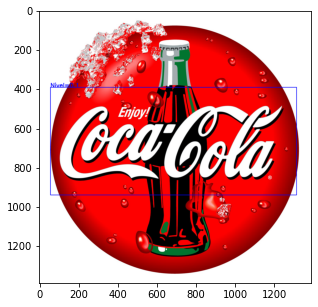

Skip since score is smaller, diff=26.739806199549786...


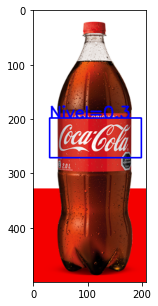

Don't skip because diff is only 4.584345682149404%
Skip since score is smaller, diff=12.383415724384164...


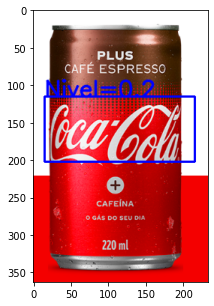

Don't skip because diff is only 1.207371409188867%
Don't skip because diff is only 2.818680115359109%
Don't skip because diff is only 1.8872983011790037%
Don't skip because diff is only 1.5565498795370238%


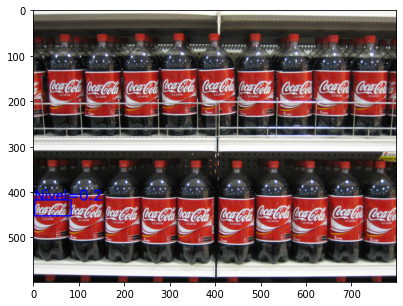

Skip since score is smaller, diff=9.806144141292075...


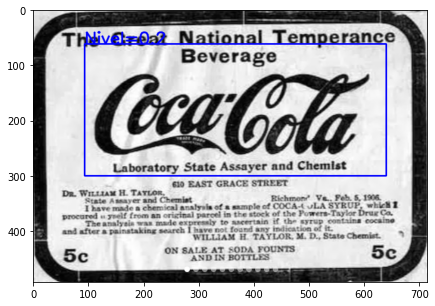

Don't skip because diff is only 5.071470968984122%
Don't skip because diff is only 2.4362045672268366%
Don't skip because diff is only 0.36594213964928335%
Don't skip because diff is only 2.9964523685519637%
Skip since score is smaller, diff=20.29346686167636...


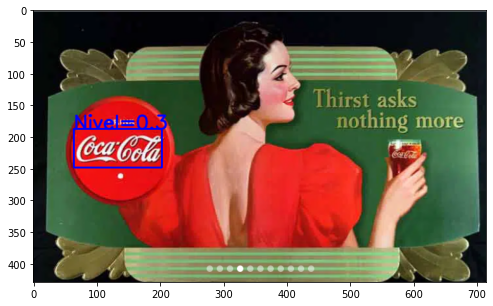

Don't skip because diff is only 0.5776836084378748%
Skip since score is smaller, diff=13.602603256952362...


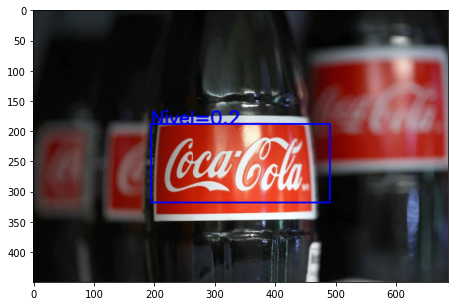

In [23]:
for i, image_name in enumerate(images):
  max_vals, coords = detect_coca_cola(image_name, 8, None)
  img_salida = cv.imread(IMAGES_PATH + image_name)
  img_salida = cv.cvtColor(img_salida, cv.COLOR_BGR2RGB)
  
  for c in range(len(max_vals)):
    cv.rectangle(img_salida, coords[c][0], coords[c][1], (0, 0, 255), 2)
    level = str(round(max_vals[c], 1))
    text_start = coords[c][0]
    cv.putText(img_salida, f'Nivel={level}', text_start, cv.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv.LINE_AA)

  # Graficamos el procesamiento y la salida
  #----------------------------------------
  plt.figure(figsize=(10,5))
  
  # Imagen original con recuadros
  plt.subplot(111),plt.imshow(img_salida)
  plt.show()

Don't skip because diff is only 1.207371409188867%
Don't skip because diff is only 2.818680115359109%
Don't skip because diff is only 1.8872983011790037%
Don't skip because diff is only 1.5565498795370238%


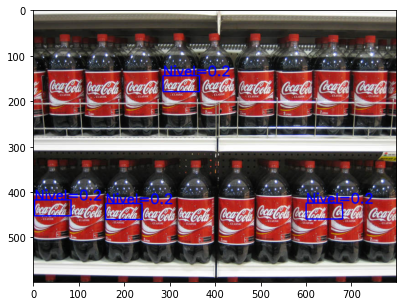

In [24]:
#busco multiples imagenes para coca_multi
images_multi = ['coca_multi.png']
for i, image_name in enumerate(images_multi):
  max_vals, coords = detect_coca_cola(image_name, 8, 0.055)
  img_salida = cv.imread(IMAGES_PATH + image_name)
  img_salida = cv.cvtColor(img_salida, cv.COLOR_BGR2RGB)

  for c in range(len(max_vals)):
    cv.rectangle(img_salida, coords[c][0], coords[c][1], (0,0,255), 2)
    level = str(round(max_vals[c], 1))
    text_start = coords[c][0]
    cv.putText(img_salida, f'Nivel={level}', text_start, cv.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv.LINE_AA)

  # Graficamos el procesamiento y la salida
  #----------------------------------------
  plt.figure(figsize=(10,5))
  
  # Imagen original con recuadros
  plt.subplot(111),plt.imshow(img_salida)
  plt.show()